<h1> 1.Problem Statement</h1>

- Given an image we had to tell whether the image has been modified/altered or not.

<h2> 1.1 Dataset Description </h2>

<p>In our dataset there are two types of images 1. Fake images and 2. Pristine Images. Fake images are the images that have been altered, corresponding to each fake image we are having a mask. Mask is telling us which part of the image has been modified. Pristine images are the images that has not been modified. There are 450 fake images and 1050 pristine images in our dataset.</p>

<h2> 1.2 Sources/Useful Links</h2>

- Dataset : http://web.archive.org/web/20171013200331/http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=5
- Research Paper : https://ieeexplore.ieee.org/abstract/document/7823911

### Evaluation Metric

- Our dataset after preprocessing is balanced, and its a classification problem where given an image we have to predict whther the image is fake or pritine. So here we are using accuracy score as our evaluation metric.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg 
from scipy.misc import imresize
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
from multiprocessing import Pool

In [2]:
print("Number of Prestine Image in the Dataset:",len(os.listdir('pristine')))
print("Number of Fake Image and Their Mask in the Dataset:",len(os.listdir('fake')))

Number of Prestine Image in the Dataset: 1050
Number of Fake Image and Their Mask in the Dataset: 450


# showing a fake image and it's corresponding mask

In [3]:
os.listdir('fake')[:2]

['010543abfbd0db1e9aa1b24604336e0c.png',
 '022354380a1a17ff49226c9eae21a11f.png']

In [4]:
img = mpimg.imread('fakemasks/010543abfbd0db1e9aa1b24604336e0c.mask.png')

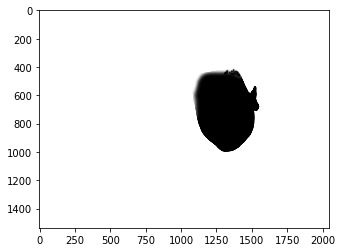

In [5]:
plt.imshow(img)

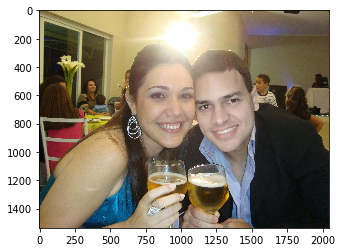

In [6]:
img = mpimg.imread('fake/010543abfbd0db1e9aa1b24604336e0c.png')
plt.imshow(img)

## Showing a Pristine Image 

In [7]:
os.listdir('pristine')[:2]

['0001d52e2fd94f30c2bca0449763a752.png',
 '000bc3906100ede4b1374cea075adedb.png']

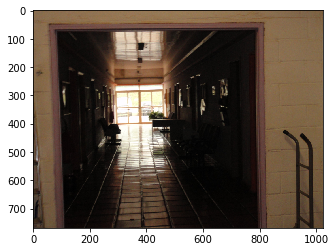

In [8]:
img = mpimg.imread('pristine/0001d52e2fd94f30c2bca0449763a752.png')
plt.imshow(img)

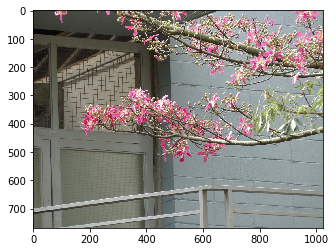

In [9]:
img = mpimg.imread('pristine/000bc3906100ede4b1374cea075adedb.png')
plt.imshow(img)

## Size of the images in the pristine and fake image dataset

In [10]:
os.path.getsize('pristine/000bc3906100ede4b1374cea075adedb.png')/(10**6)

1.412077

In [11]:
pristine_size = []
fake_mask_size = []
fake_size = []
count = 0
#calculating the pristine image size
for img in os.listdir('pristine'):
    d = os.path.getsize('pristine/'+img)/(10**6)
    pristine_size.append(d)
#calculating the fake image size
for img in os.listdir('fake'):
    d = os.path.getsize('fake/'+img)/(10**6)
    #pristine_size.append(d)
    if count%2==0:
        fake_mask_size.append(d)
    else:
        fake_size.append(d)
    count = count+1

Text(0.5, 1.0, 'CDF for Pristine Image Size')

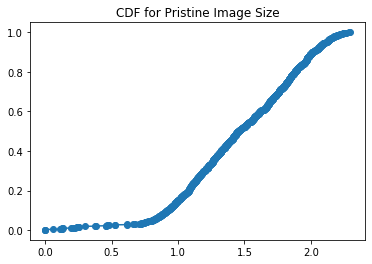

In [12]:
X=sorted(pristine_size)
Y=[]
l=len(X)
Y.append(float(1)/l)
for i in range(2,l+1):
    Y.append(float(1)/l+Y[i-2])
plt.plot(X,Y,marker='o',label='xyz')
plt.title('CDF for Pristine Image Size')

Text(0.5, 1.0, 'CDF for Fake Image Size')

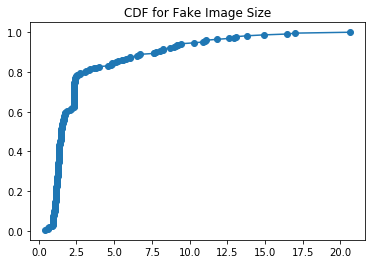

In [13]:
X=sorted(fake_size)
Y=[]
l=len(X)
Y.append(float(1)/l)
for i in range(2,l+1):
    Y.append(float(1)/l+Y[i-2])
plt.plot(X,Y,marker='o',label='xyz')
plt.title('CDF for Fake Image Size')

### seperating fake images and their mask 

In [14]:
## create seperate folder for fake images and it's mask
if not os.path.isdir('fakemasks/'):
    os.mkdir('fakemasks/')
    for fake in os.listdir('fake'):
        if len(fake.split('.'))==3:
            shutil.move('fake/'+fake,'fakemasks/'+fake)
else:
    print('Already done')

Already done


## Check the size of the fake images, mask and pristine images

In [15]:
fake = os.listdir('fakemasks/')

In [16]:
count = 0
for f in fake:
    if count==10:
        break
    print("Shape of "+ f +"------>"+str(mpimg.imread('fakemasks/'+f).shape))
    count = count+1

Shape of 010543abfbd0db1e9aa1b24604336e0c.mask.png------>(1536, 2048, 4)
Shape of 022354380a1a17ff49226c9eae21a11f.mask.png------>(768, 1024)
Shape of 0294345b3b2324b195cb3b30e91d7678.mask.png------>(600, 800, 4)
Shape of 0363353570f16ff0a73aa0a03a7795b8.mask.png------>(765, 1024)
Shape of 0830004e471e511458600f0763ce19f3.mask.png------>(768, 1024)
Shape of 08829849d0b1c71e437961e841e0c81f.mask.png------>(768, 1024)
Shape of 0908dafde12041540b70d688315df6e9.mask.png------>(2736, 3648, 3)
Shape of 092b43f88eab0ae3ecc0eb0ccbe37c82.mask.png------>(2736, 3648, 3)
Shape of 12362143f7e114beeb9d22dc59450f5a.mask.png------>(768, 1024)
Shape of 14548214e97adf237ee3bac90809baf6.mask.png------>(768, 1024)


In [17]:
count = 0
for f in os.listdir('fakemasks')[:]:
    if len(mpimg.imread('fakemasks/'+f).shape)==3 and  (mpimg.imread('fakemasks/'+f).shape[2] > 3 or mpimg.imread('fakemasks/'+f).shape[2] < 3) :
        print("Shape of "+ f +"------>"+str(mpimg.imread('fakemasks/'+f).shape))

Shape of 010543abfbd0db1e9aa1b24604336e0c.mask.png------>(1536, 2048, 4)
Shape of 0294345b3b2324b195cb3b30e91d7678.mask.png------>(600, 800, 4)
Shape of 152681a0017a5fded699c43cd6df97d1.mask.png------>(1536, 2048, 4)
Shape of 17030938cc2cb314cb87552dcc9516a4.mask.png------>(1536, 2048, 4)
Shape of 1848de26a06a7831457609429c92e2e7.mask.png------>(768, 1024, 4)
Shape of 1990a2ed067b8c537d8fe36d1ab4a7f2.mask.png------>(1200, 1800, 4)
Shape of 207763f02c2c5881c898386782da1728.mask.png------>(1536, 2048, 4)
Shape of 244a7433a307b9a2c839cefe14c0ba1d.mask.png------>(1637, 2352, 4)
Shape of 2564876058a684e6d899f3575081b16f.mask.png------>(1536, 2048, 4)
Shape of 30096e4b0cdadb88b548f4fa2aee4b95.mask.png------>(1536, 2048, 4)
Shape of 31311633f92518299051f6c846919af1.mask.png------>(480, 640, 4)
Shape of 31682dc53f670f43d4308f7e99a1d3f8.mask.png------>(1536, 2048, 4)
Shape of 44061b655cd1191b0f0e8a19a0e7e69d.mask.png------>(600, 800, 4)
Shape of 49885ceb0d7868353754bcdc653fd85a.mask.png------>(

In [18]:
count = 0
for f in os.listdir('fake'):
    try:
        print("Shape of "+ f +"------>"+str(mpimg.imread('fake/'+f).shape))
        count = count+1
    except:
        continue

Shape of 010543abfbd0db1e9aa1b24604336e0c.png------>(1536, 2048, 4)
Shape of 022354380a1a17ff49226c9eae21a11f.png------>(768, 1024, 3)
Shape of 0294345b3b2324b195cb3b30e91d7678.png------>(600, 800, 4)
Shape of 0363353570f16ff0a73aa0a03a7795b8.png------>(765, 1024, 3)
Shape of 0830004e471e511458600f0763ce19f3.png------>(768, 1024, 3)
Shape of 08829849d0b1c71e437961e841e0c81f.png------>(768, 1024, 3)
Shape of 0908dafde12041540b70d688315df6e9.png------>(2736, 3648, 3)
Shape of 092b43f88eab0ae3ecc0eb0ccbe37c82.png------>(2736, 3648, 3)
Shape of 12362143f7e114beeb9d22dc59450f5a.png------>(768, 1024, 3)
Shape of 14548214e97adf237ee3bac90809baf6.png------>(768, 1024, 3)
Shape of 152681a0017a5fded699c43cd6df97d1.png------>(1536, 2048, 4)
Shape of 17030938cc2cb314cb87552dcc9516a4.png------>(1536, 2048, 3)
Shape of 1848de26a06a7831457609429c92e2e7.png------>(768, 1024, 4)
Shape of 1990a2ed067b8c537d8fe36d1ab4a7f2.png------>(1200, 1800, 4)
Shape of 207763f02c2c5881c898386782da1728.png------>(1536

Shape of bcbc7bef972e1b0ad0ebf8d4781aba31.png------>(768, 1024, 3)
Shape of bcd5608b3999bb8d454d0903fc3bd759.png------>(768, 1024, 3)
Shape of bd0b360b1e221acee0e0ba4970556271.png------>(768, 1024, 3)
Shape of bd102f5038b9c07483b7e76eb614de0a.png------>(1536, 2048, 3)
Shape of bd162a474c3726de6e7b9790feb95a00.png------>(768, 1024, 3)
Shape of bd2dc6a591234f7855101bb3e66c96c8.png------>(768, 1024, 3)
Shape of bd514860151bb8fcfb448276821f0ac9.png------>(768, 1024, 3)
Shape of bd993ecb7172acc9508e2d74fa239e6c.png------>(768, 1024, 3)
Shape of bdaed1accdd28cf71be52229b654c0fd.png------>(768, 1024, 3)
Shape of be015078936ab89c8c755cf290ba9a0f.png------>(768, 1024, 3)
Shape of be05023fef0c596b1691471cb7095d12.png------>(768, 1024, 3)
Shape of be07c00a9019c724132920b410951478.png------>(771, 1024, 3)
Shape of be3c9e989860de924073c3b60aae71bd.png------>(771, 1024, 3)
Shape of be51269d525b84339af824a319814cda.png------>(768, 1024, 4)
Shape of bea810fbe5f0ee59c79b4ebd4732f1a0.png------>(1936, 25

Shape of d321ba188146edd239c266f409e7995e.png------>(768, 1024, 3)
Shape of d3389a52075cb3af01ee0b164c75019d.png------>(1109, 1663, 3)
Shape of d34431a82f1e24ef7ef228dae9eb8c4c.png------>(768, 1024, 3)
Shape of d38f15e7ee1656b427fc23cea9944691.png------>(595, 1025, 4)
Shape of d402dcd0cbd09bcc950a22003b8251b4.png------>(792, 1188, 3)
Shape of d40f3ba9fd4d86bd79dd02a5104c16c1.png------>(768, 1024, 3)
Shape of d4aff0ad5f4f99fc6cad4243b926eda7.png------>(768, 1024, 3)
Shape of d4c52c98840e8128d50e0cd73068ccd3.png------>(1067, 1600, 3)
Shape of d4e7b59257c600b426046bed3a7da516.png------>(806, 1075, 3)
Shape of d4fed2657cb159dd112be532b7678d20.png------>(768, 1024, 3)
Shape of d50705dec19859abe19deb5c3af5f3bd.png------>(1286, 1709, 3)
Shape of d507e807f025f09ea0cff40b52e9322c.png------>(768, 1024, 3)
Shape of d52264908b734ce04d2f4da2a07f531d.png------>(768, 1024, 3)
Shape of d531b1cefbdd804a28399c46965aba52.png------>(768, 1024, 4)
Shape of d55e4723d6de869b76020bcc1c4cfa26.png------>(768, 1

In [19]:
count = 0
for f in os.listdir('fake')[:]:
    try:
        if len(mpimg.imread('fake/'+f).shape)==3 and  (mpimg.imread('fake/'+f).shape[2] > 3 or mpimg.imread('fake/'+f).shape[2] < 3) :
            print("Shape of "+ f +"------>"+str(mpimg.imread('fake/'+f).shape))
    except:
        continue

Shape of 010543abfbd0db1e9aa1b24604336e0c.png------>(1536, 2048, 4)
Shape of 0294345b3b2324b195cb3b30e91d7678.png------>(600, 800, 4)
Shape of 152681a0017a5fded699c43cd6df97d1.png------>(1536, 2048, 4)
Shape of 1848de26a06a7831457609429c92e2e7.png------>(768, 1024, 4)
Shape of 1990a2ed067b8c537d8fe36d1ab4a7f2.png------>(1200, 1800, 4)
Shape of 207763f02c2c5881c898386782da1728.png------>(1536, 2048, 4)
Shape of 244a7433a307b9a2c839cefe14c0ba1d.png------>(1637, 2352, 4)
Shape of 2564876058a684e6d899f3575081b16f.png------>(1536, 2048, 4)
Shape of 30096e4b0cdadb88b548f4fa2aee4b95.png------>(1536, 2048, 4)
Shape of 31311633f92518299051f6c846919af1.png------>(480, 640, 4)
Shape of 31682dc53f670f43d4308f7e99a1d3f8.png------>(1536, 2048, 4)
Shape of 44061b655cd1191b0f0e8a19a0e7e69d.png------>(600, 800, 4)
Shape of 65356dc39286084901856e5cae427764.png------>(1536, 2048, 4)
Shape of 687764119688d5ee49717027e6145bee.png------>(1536, 2048, 4)
Shape of 72366b10b23899d659b3b0fa92d3a73c.png------>(27

In [20]:
count = 0
for f in os.listdir('pristine')[:]:
    if count==30:
        break
    print("Shape of "+ f +"------>"+str(mpimg.imread('pristine/'+f).shape))
    count = count+1

Shape of 0001d52e2fd94f30c2bca0449763a752.png------>(768, 1024, 3)
Shape of 000bc3906100ede4b1374cea075adedb.png------>(768, 1024, 3)
Shape of 002e23c036a05de656242f5ce6ab2e15.png------>(768, 1024, 3)
Shape of 003f2d6e572e2587ffa809f78ff4a5c4.png------>(768, 1024, 3)
Shape of 00d56bffe2d757a4e4625cc2d0bd0de9.png------>(768, 1024, 3)
Shape of 00dd93f9e4af553929e54e66c2a3186e.png------>(683, 1024, 3)
Shape of 00dffa8cb9db22527454bfa3c03b484b.png------>(768, 1024, 3)
Shape of 00e079b66d9e9f99892bbb81d9d6cd57.png------>(768, 1024, 3)
Shape of 00e3659be9c1fec47c739f79252840e3.png------>(683, 1024, 3)
Shape of 00ec0ffe0cd029ad4551680484a007d7.png------>(768, 1024, 3)
Shape of 00f2590c9968d4f36464ead50585e6eb.png------>(768, 1024, 3)
Shape of 00f2eadf3c83c55da30868177dfdc62d.png------>(768, 1024, 3)
Shape of 00fbcae4d05aeab62ab917e587b911f9.png------>(681, 1024, 3)
Shape of 01aa04db92eb2617ebfe69ffe32b1bdd.png------>(768, 1024, 3)
Shape of 01c86605fa24b57755ef6797443213d9.png------>(768, 1024

In [22]:
count = 0
for f in os.listdir('pristine')[:]:
    if 3 > mpimg.imread('pristine/'+f).shape[2] > 3:
        print("Shape of "+ f +"------>"+str(mpimg.imread('pristine/'+f).shape))  #all the pristine images are having only 3 channels

1. From the above result we can see that mask of the fake images are 1 channel, 3 channel, and 4 channel.
2. Fake images are having either 3 channel or 4 channel.
3. Number of channel in all the pristine images are 3 only.

## Segregating different channel images 

In [30]:
pristines_final=[]
pristine_images= []
for pristine in os.listdir('pristine'):
    img=imread('pristine/'+pristine)
    if len(imread('pristine/'+pristine).shape)<3:
        continue
    if imread('pristine/'+pristine).shape[2]>3:
        continue
    pristines_final.append(img)
    pristine_images.append(pristine)

In [31]:
os.listdir('pristine')[0:10]

['0001d52e2fd94f30c2bca0449763a752.png',
 '000bc3906100ede4b1374cea075adedb.png',
 '002e23c036a05de656242f5ce6ab2e15.png',
 '003f2d6e572e2587ffa809f78ff4a5c4.png',
 '00d56bffe2d757a4e4625cc2d0bd0de9.png',
 '00dd93f9e4af553929e54e66c2a3186e.png',
 '00dffa8cb9db22527454bfa3c03b484b.png',
 '00e079b66d9e9f99892bbb81d9d6cd57.png',
 '00e3659be9c1fec47c739f79252840e3.png',
 '00ec0ffe0cd029ad4551680484a007d7.png']

In [64]:
fake_images=[]
final_fake=[]
for fake in os.listdir('fake/'):
    img=imread('fake/' + fake)
    try:
        fake_images.append(img[:,:,:3])
        final_fake.append(fake)
    except IndexError:
        print(f'image {fake} has only 1 channel')

In [65]:
final_mask=[]
mask_images = []
for f in os.listdir('fakemasks/'):
    img=imread('fakemasks/'+f)
    final_mask.append(img)
    mask_images.append(f)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [66]:
print("Length of fake images in the dataset :",len(final_fake))
print("Number of pristine images in the dataset",len(pristines_final))
print("Number of mask images :",len(final_mask))

Length of fake images in the dataset : 450
Number of pristine images in the dataset 1025
Number of mask images : 450


## Sample fake image and it's mask

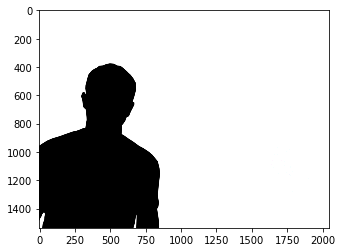

In [74]:
plt.imshow(final_mask[10])

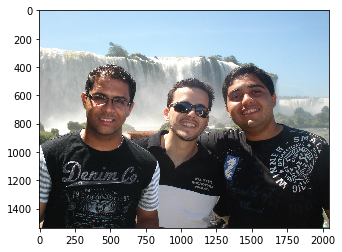

In [73]:
plt.imshow(fake_images[10])

## converting mask from Gray Scale to Binary Scale

In [30]:
# Reference : https://stackoverflow.com/questions/48729656/how-to-convert-grayscale-image-to-binary-image-and-reverse-in-python
import cv2

count = 0
for mask in os.listdir('fakemasks/'):
    if not os.path.isdir('binarymask/'):
        os.mkdir('binarymask/')
    im_gray = cv2.imread('fakemasks/'+mask, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 127
    
    im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite('binarymask/'+mask, im_bw)
    if count%10==0:
        print(count,"done")
    count = count+1

0 done
10 done
20 done
30 done
40 done
50 done
60 done
70 done
80 done
90 done
100 done
110 done
120 done
130 done
140 done
150 done
160 done
170 done
180 done
190 done
200 done
210 done
220 done
230 done
240 done
250 done
260 done
270 done
280 done
290 done
300 done
310 done
320 done
330 done
340 done
350 done
360 done
370 done
380 done
390 done
400 done
410 done
420 done
430 done
440 done


## Reading Binary Representation of  Mask 

In [11]:
final_mask_b=[]
mask_images_b = []
for f in os.listdir('binarymask/'):
    img=imread('binarymask/'+f)
    final_mask_b.append(img)
    mask_images_b.append(f)

In [113]:
final_mask[20][0],final_mask[20][1].shape,final_mask[20][2].shape

((3,), (2816, 3), (2816, 3))

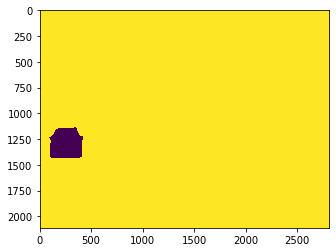

In [96]:
plt.imshow(final_mask_b[20])

In [75]:
final_mask_b=[]
mask_images_b = []
for f in os.listdir('binarymask/'):
    img=imread('binarymask/'+f)
    final_mask_b.append(img)
    mask_images_b.append(f)

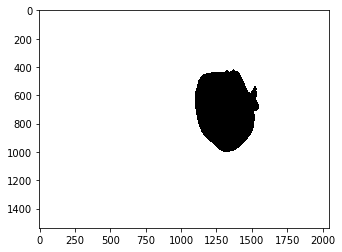

In [97]:
plt.imshow(final_mask_b[0],cmap='gray')

In [79]:
## various values of in the image representation
np.unique(final_mask[20])

Array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [95]:
type(final_mask_b)

list

In [40]:
## after converting image to binary representation, unique values in binary representation
np.unique(final_mask_b[20])

Array([  0, 255], dtype=uint8)

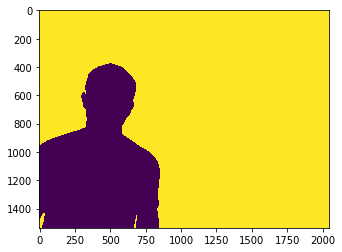

In [126]:
plt.imshow(final_mask_b[10])

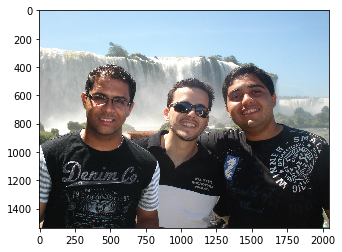

In [128]:
plt.imshow(fake_images[10])

In [130]:
fake_images[10].shape

(1536, 2048, 3)

In [131]:
temp = final_mask_b[0]
pix_count=0
for i in range(temp.shape[0]):       # counting the 255 values in the temp image part
    for j in range(temp.shape[1]):
        if temp[i,j]!=255:
            pix_count+=1

In [132]:
pix_count,final_mask_b[0].shape

(195369, (1536, 2048))

## Creating the dataset for fake images by taking mask

1. We are masing with the 64*64 size of the mask image.
2. Out of 64*64 size of the masked image at least 25% should come from the fake part 
3. So 64*64*25/100 = 1024 pixels should be filled with value 255. 

In [153]:
#reference : https://note.nkmk.me/en/python-opencv-numpy-alpha-blend-mask/
def multiprocessing(img,mask,count):
    #img,mask = data[0],data[1]
    k_size = 64   # size of the kernel
    threshold=1024
    #count = 0

    for k in range(0, img.shape[0] - k_size + 1, 8):
        for l in range(0, img.shape[1] - k_size + 1, 8):
            
            temp = mask[k:k + k_size, l:l + k_size]  # taking the portion of the mask image 
            pix_count=0
            for i in range(temp.shape[0]):       # counting the 255 values in the temp image part
                for j in range(temp.shape[1]):
                    if temp[i,j]==255:
                        pix_count+=1

            if (pix_count > 1600) and (k_size * k_size - pix_count > 1600):     ## testing the condtion
                count = count+1
                mod = img[k:k + k_size, l:l + k_size, :3]
                #imageio.imwrite('final_fake/'+str(count)+'.png', mod) #to run the code remove the comment
    return int(count)

In [152]:
count = 0
for i in range(len(fake_images)):
    count = multiprocessing(fake_images[10],final_mask_b[10],count)
    count = count+1
    print("Total Image Generated : ",count)

Total Image Generated :  469


## final preprocessed dataset

In [25]:
print("Number of Preprocessed fake images :",len(os.listdir('final_fake/')))
print("Number of Preprocessed fake images :",len(os.listdir('final_orginal/')))  ## these images has been generated by second notebook file

Number of Preprocessed fake images : 237515
Number of Preprocessed fake images : 310282
